# Text Mining Coursework 2
## Topic: WinterOlympics
Team members: 
Bushui Zhang (UID: 10407579), Yazhuo Cao (UID: 10329221), Yecheng Chu (UID: 10319044), Zhaoyu Zhang (UID:10838545), Zhengqian Jin (UID:10839527)
### 3 Questions: 
1) What were the most talked about topics for the Winter Olympics?

2) What is the dominant sentiment towards the Winter Olympics?

3) Which 2 countries have been mostly talked about during Winter Olympics? What do people think of them?

## Libraries Used

In [20]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

# ignore warnings for now
warnings.filterwarnings("ignore")

# may need to download a few packages
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

# Configuring Twitter API

In [2]:
# auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20 lang:en" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [3]:
tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])
# print(tweet_urls)

## Convert urls to tweets

In [4]:
# Extract the tweet id
tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]
# Store tweet id in another column
tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
ids = tweet_urls['tweet_ids'].tolist()

def url2tweet(IDs): # a list of ids, max 100
    all_status = api.lookup_statuses(IDs)
    tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
    return tweets_list


def get_all_tweets(IDs): # a list of ids
    num_sections = (len(IDs) - 1) // 100 + 1
    first_section = ids[:100]
    data = url2tweet(first_section)
    for i in tqdm(range(1, num_sections)):
        current_ids = ids[i*100:(i+1)*100]
        current_tweet_list = url2tweet(current_ids)
        data = np.concatenate([data, current_tweet_list])
    return data

data = get_all_tweets(ids)

In [5]:
tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
tweets_df.head(len(tweets_df))

,date,user,location,text
0,2022-02-19 23:45:01+00:00,NEWS CENTER Maine,"Maine, USA",Tonight at 7:30: Our final Olympic Zone show o...
1,2022-02-19 23:47:19+00:00,Nicoya,Lincolnshire,"#WinterOlympics Up early for #menscurling , af..."
2,2022-02-19 23:12:02+00:00,Sweepers Curling 🥌,Edinburgh,@Team_Muirhead @richardosman Honestly! 2 hours...
3,2022-02-19 23:55:43+00:00,Georgie Heath,"London, England",To sleep and set curling alarm or just stay up...
4,2022-02-19 23:04:20+00:00,Sports update.,World,#WinterOlympics: Sweden beat Switzerland to wi...
...,...,...,...,...
52258,2022-02-04 00:00:13+00:00,NBC Connecticut,Connecticut,Cecily from Wallingford is ready to cheer on @...
52259,2022-02-04 00:04:17+00:00,UofSC College of HRSM,"Columbia, South Carolina",Sport and Entertainment Management Professor M...
52260,2022-02-04 00:00:02+00:00,Global Times,"Beijing, China",#GTGraphic: Welcome to China! When the #Beijin...
52261,2022-02-04 00:28:52+00:00,BetRivers,AZ/CO/IA/IL/IN/LA/MI/NY/PA/VA,🥌 TONIGHT 🥌\n\nanyone have some mixed curling ...


# Data Cleaning

In [6]:
def remove_emoji(string):
    string = emoji.get_emoji_regexp().sub(u'', string)
    return string

# emojis = '(｀ヘ´) 🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩🥌🍒💚🏅'
# print(remove_emoji(emojis))

In [7]:
def data_cleaning(data):
    # Remove hyperlinks
    data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

    # Remove punctuation
    data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

    # Remove unnecessary line breaks
    data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

    # Convert the titles to lowercase
    data.text = data.text.map(lambda x: x.lower())

    # Remove emojis
    data.text = data.text.map(lambda x: remove_emoji(x))

In [8]:
# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

data_cleaning(tweets_df)

# store the processed tweets to csv
tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 1: What were people mostly talked about for the Winter Olympics?

## Exploration using a word cloud

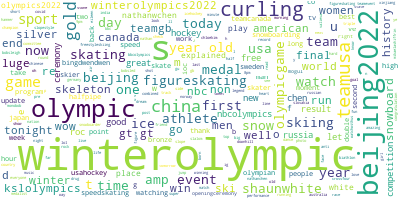

In [9]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets_all = list(set(list(tweets_df['text'].values)))
unique_tweets_all = [t for t in unique_tweets_all if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets_all)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [10]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'winterolympic', 'olympic', 'winterolympics',
                   'olympics', 'beijing','winterparalympic', 'beijing2022', 'winter', 'today', 'like', 
                   'would', 'watch', 'tonight', 'first', 'time', 'go', 'next', 'events', 'let', 
                   'love', 'year', 'watching', 'day', 'run', 'big', 'live', 'know', 'well','going', 'great'
                   , 'get', 'one', 'good', 'th', 'white', 'back','game', 'amp', 'end', 'see', 'watchwithus'
                   , 'much'])

# print(stop_words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

## Get the Mostly Talked Topics

In [11]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.012*"curling" + 0.011*"skating" + 0.010*"gold" + 0.009*"figure" + '
  '0.008*"figureskating" + 0.008*"teamusa" + 0.007*"sport" + 0.007*"women" + '
  '0.005*"men" + 0.005*"nathan"'),
 (1,
  '0.012*"curling" + 0.012*"medal" + 0.011*"gold" + 0.010*"teamusa" + '
  '0.008*"team" + 0.006*"ice" + 0.005*"athletes" + 0.005*"snowboarding" + '
  '0.005*"mixed" + 0.004*"event"'),
 (2,
  '0.016*"gold" + 0.011*"medal" + 0.009*"china" + 0.009*"curling" + '
  '0.009*"ceremony" + 0.008*"teamusa" + 0.007*"women" + 0.007*"opening" + '
  '0.007*"team" + 0.007*"skating"'),
 (3,
  '0.019*"curling" + 0.013*"team" + 0.011*"usa" + 0.010*"teamusa" + '
  '0.008*"women" + 0.008*"men" + 0.007*"hockey" + 0.007*"skating" + '
  '0.006*"best" + 0.005*"gold"'),
 (4,
  '0.009*"team" + 0.009*"women" + 0.007*"gold" + 0.006*"china" + '
  '0.005*"teamusa" + 0.005*"usa" + 0.004*"win" + 0.004*"curling" + '
  '0.004*"congratulations" + 0.004*"us"')]


### Visualise the topics

In [12]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.045054  0.011672       1        1  22.744186
2      0.017232 -0.077168       2        1  21.203771
3     -0.024353  0.055348       3        1  20.139979
1     -0.036516 -0.018397       4        1  19.751708
4      0.088691  0.028545       5        1  16.160355, topic_info=               Term         Freq        Total Category  logprob  loglift
690        ceremony  1012.000000  1012.000000  Default  30.0000  30.0000
48          skating  2248.000000  2248.000000  Default  29.0000  29.0000
32            medal  2575.000000  2575.000000  Default  28.0000  28.0000
3594        opening  1133.000000  1133.000000  Default  27.0000  27.0000
26          curling  4391.000000  4391.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
354           short   167.479254   778.928869   Topic5  -5.9037   0.2855
32            medal   237.296135  2575.294344   Topic5  -5.5553  -0.5618
0          athletes   188.817995  1274.315582   Topic5  -5.7838  -0.0868
26          curling   269.409952  4391.953799   Topic5  -5.4283  -0.9687
257   figureskating   200.971898  1625.517401   Topic5  -5.7214  -0.2678

[466 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
18078      4  0.844515    abdi
228        1  0.090014  action
228        2  0.064698  action
228        3  0.323488  action
228        4  0.416315  action
...      ...       ...     ...
10218      1  0.827445    zhou
10218      2  0.025858    zhou
10218      3  0.025858    zhou
10218      4  0.129288    zhou
10218      5  0.025858    zhou

[1136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

## Hence, from the visualisation above we can conclude, people were mostly talked about these topics for the Winter Olympics:
$ Gold medal $, $curling$, $skating$, $china$, $woman$ and $team USA$

# Task 2: What is the dominant sentiment towards the Winter Olympics?

## Sentiment Analysis

In [13]:
all_pos = 0
all_neg = 0
all_neu = 0
all_compounds = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos += 1
        elif compound_score <= -0.05:
            all_neg += 1
        else:
            all_neu += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds.append(general_compound_score)

In [14]:
print(all_compounds)
print(all_pos)
print(all_neg)
print(all_neu)

[0.1893660398230087, 0.16643525214081806, 0.19066612267867178, 0.17679528824833696, 0.18534860173577652, 0.20060541455160813, 0.2537286676646708, 0.1702559116022102, 0.22960512117055354, 0.21544001016776826, 0.21018018867924576, 0.18604420062695978, 0.17741429885057486, 0.20033238060781464, 0.2064918638439186, 0.24066023752969148]
24205
7746
18646


## Visualise the result

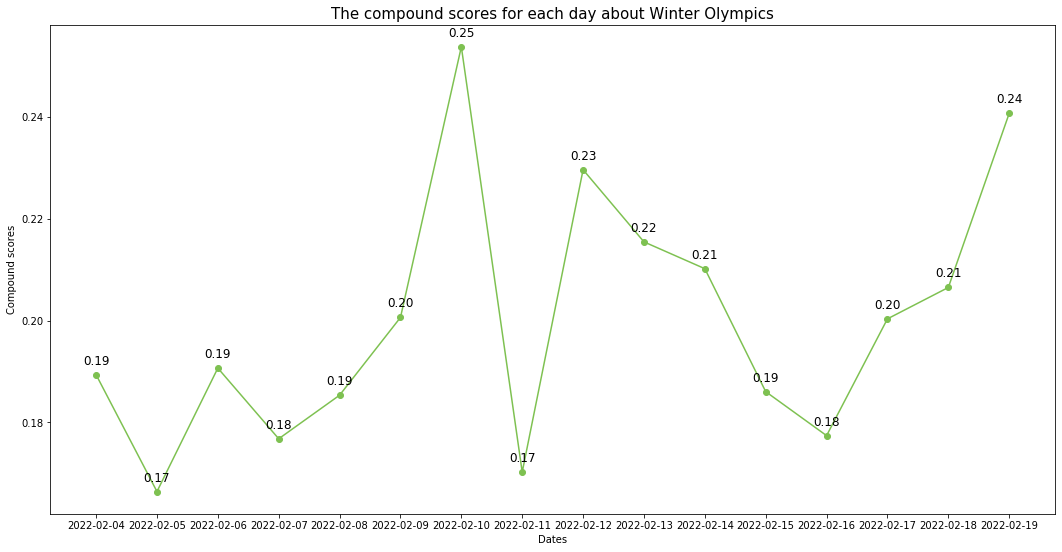

In [15]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds, 'o-', color = '#7EC151')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
plt.title("The compound scores for each day about Winter Olympics", fontsize=15)
x = dates
y = np.array(all_compounds)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.0015, '%.2f'%_y, ha='center', va='bottom', size=12, c='black')
plt.show()

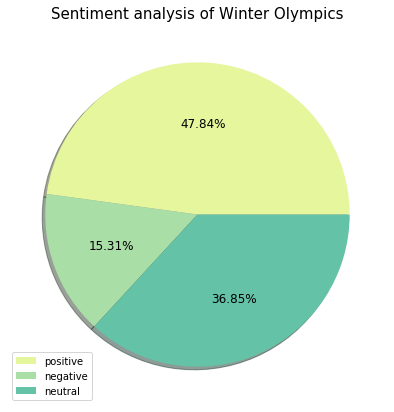

In [16]:
plt.figure(figsize=(7,7))
senti_data = [all_pos, all_neg, all_neu]
labels = ['positive', 'negative', 'neutral']
colours = ['#E6F69D','#AADEA7','#64C2A6']
plt.pie(senti_data,autopct='%1.2f%%',textprops={'fontsize': 12}, colors=colours,shadow=True)
plt.title('Sentiment analysis of Winter Olympics', fontsize=15)
plt.legend(labels)
plt.show()

# Task 3: Which 2 countries have been mostly talked about during Winter Olympics? What do people think of them?

## Named Entity Recognition

In [17]:
nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

Uncomment the lines in the cell below to do named entity recognision.
As the amount of unique tweets is huge, it may take more than __one hour__ to run.

In [21]:
countries = {}
stop_words = ['beijing2022', 'beijing']
pbar = tqdm("progess(for loop)", total = len(unique_tweets_all))
for tweet_text in unique_tweets_all:
    doc = nlp(tweet_text)
    pbar.update(1)
    for ne in doc.ents:
        if ne.label_ == 'GPE':
            tweet = tweet_text[ne.start_char:ne.end_char]
            if tweet not in stop_words and tweet not in countries.keys():
                countries[tweet] = 1
            elif tweet not in stop_words:
                countries[tweet] += 1

In [22]:
with open('countries.pkl', 'wb') as f:
    pickle.dump(countries, f)
        
with open('countries.pkl', 'rb') as f:
    countries = pickle.load(f)

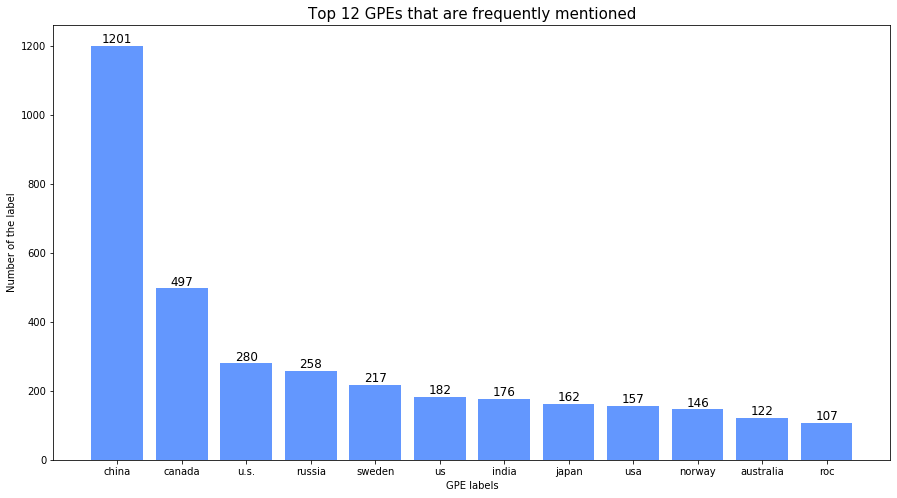

In [23]:
countries = {k: v for k, v in sorted(countries.items(), key=lambda item: item[1], reverse=True)}
names = list(countries.keys())[0:12]
values = list(countries.values())[0:12]
plt.figure(figsize=(15,8))
plt.ylabel('Number of the label')
plt.xlabel('GPE labels')
plt.title('Top 12 GPEs that are frequently mentioned', fontsize=15)

plt.bar(range(12), values, tick_label=names, color = '#6397FE')
for _x, _y in zip(np.arange(12), values):
    plt.text(_x, _y, _y, ha='center', va='bottom', size=12, c='black')
plt.show()

In [24]:
mostly_talked_country = list(countries.keys())[0]
second_talked_country = list(countries.keys())[1]
print("As the bar chart shows, the 2 mostly talked countries are " + mostly_talked_country + " and " + second_talked_country)

As the bar chart shows, the 2 mostly talked countries are china and canada


In [25]:
all_pos_m = 0
all_neg_m = 0
all_neu_m = 0
all_compounds_m = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(mostly_talked_country)]
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos_m += 1
        elif compound_score <= -0.05:
            all_neg_m += 1
        else:
            all_neu_m += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds_m.append(general_compound_score)

In [26]:
all_pos_s = 0
all_neg_s = 0
all_neu_s = 0
all_compounds_s = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(second_talked_country)]
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos_s += 1
        elif compound_score <= -0.05:
            all_neg_s += 1
        else:
            all_neu_s += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds_s.append(general_compound_score)

## Visualise the result

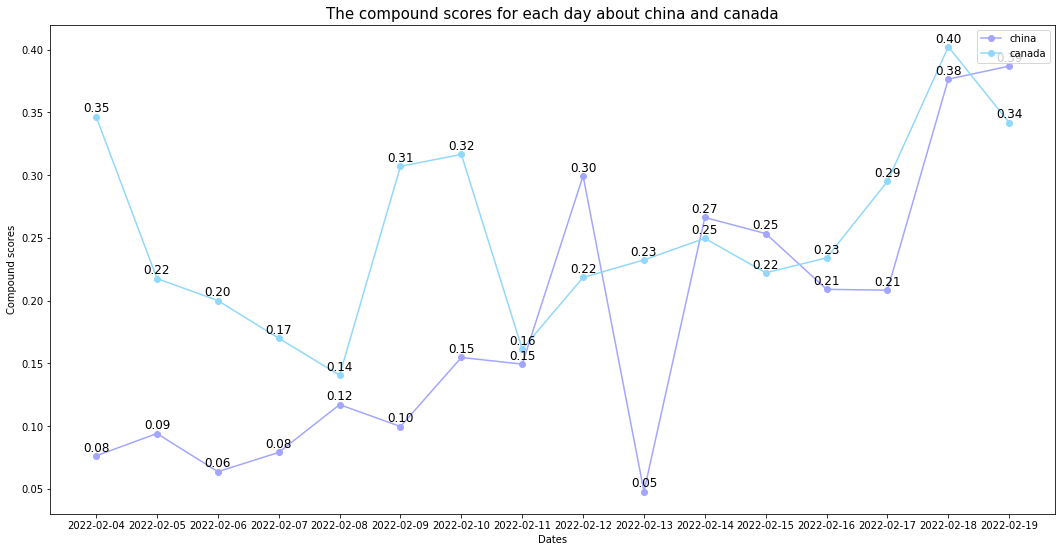

In [27]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds_m, 'o-', color = '#A3A6FE', label = mostly_talked_country)
plt.plot(all_compounds_s, 'o-', color = '#92D8FB', label = second_talked_country)
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
title_plt = "The compound scores for each day about " + mostly_talked_country + " and " + second_talked_country
plt.legend()
plt.title(title_plt, fontsize=15)
x = dates
y1 = np.array(all_compounds_m)
y2 = np.array(all_compounds_s)
for _x, _y1, _y2 in zip(x, y1, y2):
    plt.text(_x-4, _y1+0.0015, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x-4, _y2+0.0015, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.show()

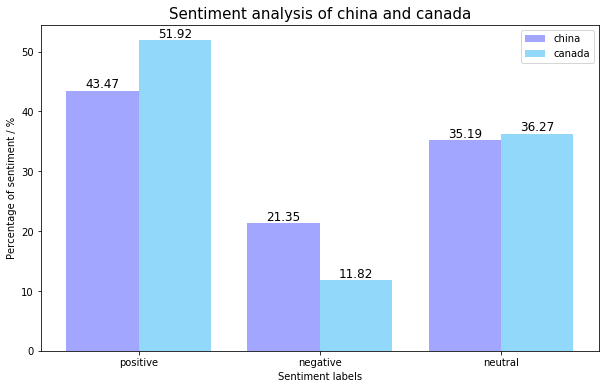

In [28]:
all_m = all_pos_m + all_neg_m + all_neu_m
all_s = all_pos_s + all_neg_s + all_neu_s
all_pos_pm = (all_pos_m / all_m) * 100
all_neg_pm = (all_neg_m / all_m) * 100
all_neu_pm = (all_neu_m / all_m) * 100
all_pos_ps = (all_pos_s / all_s) * 100
all_neg_ps = (all_neg_s / all_s) * 100
all_neu_ps = (all_neu_s / all_s) * 100
all_pm = [all_pos_pm, all_neg_pm, all_neu_pm]
all_ps = [all_pos_ps, all_neg_ps, all_neu_ps]
names = ['positive', 'negative', 'neutral']
plt.figure(figsize=(10,6))
plt.ylabel('Percentage of sentiment / %')
plt.xlabel('Sentiment labels')
title_plt = "Sentiment analysis of " + mostly_talked_country + " and " + second_talked_country
plt.title(title_plt, fontsize=15)

X_axis = np.arange(3)
plt.xticks(X_axis, names)
plt.bar(X_axis - 0.2, all_pm,0.4,label=mostly_talked_country, color = '#A3A6FE')
plt.bar(X_axis + 0.2, all_ps,0.4,label=second_talked_country, color = '#92D8FB')
for _x, _y1, _y2 in zip(np.arange(3), all_pm, all_ps):
    plt.text(_x-0.2, _y1, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x+0.2, _y2, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.legend()